# Figure 1b
# Learning trajectories for DD Linear Regression Games

We extend the linear regression example from Miller et. al. (http://arxiv.org/abs/2102.08570) to the multiplayer framework where the models of each player affect the distributions of data seen by all.

In [1]:
import numpy as np
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *
from dfo_player import *
from rgd_player import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

np.random.seed(10)

# Configurations

In [2]:
d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_0 = 0.3
epsilon_1 = 0.3  # Epsilon sensitivity parameters
epsilon_2 = 0.3

Sigma_x_p1 = np.eye(d_1)  # Covariance of x_k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.1  # Variance of y_k
sigma_y_p2 = 0.1

beta_p1 = np.random.normal(size=d_1)  # Linear parameter vector
beta_p2 = np.random.normal(size=d_2)

mu_p1 = sample_sphere(epsilon_0,d_1)
gamma_p1 = sample_sphere(epsilon_1,d_2)  # Performativity parameters
mu_p2 = sample_sphere(epsilon_0,d_2)
gamma_p2 = sample_sphere(epsilon_2,d_1)

p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

num_rounds_lst = np.logspace(1,5,10,dtype='int')
num_alternate_rounds = 100
num_test = 1000

# Run Algorithm 1

In [3]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_two = TwoStagePlayer()
    player_one = TwoStagePlayer()
    game = DecisionDependentGame(player_one, player_two,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_rounds, num_alternate_rounds, num_test)
    
    game.run_train()
    game.run_post_train_alternating()
    
    PR1, PR2 = game.evaluate_closed_perf_risk()
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game.theta_p1)
    theta_final_p2.append(game.theta_p2)
    
    #Change this flag to change print settings
    if False:
        print("---------------------")
        print("Player 1: Actual mu, gamma")
        print(mu_p1, gamma_p1)
        print("Player 1: Estimated mu, gamma")
        print(player_one.mu_hat, player_one.gamma_hat)

        print("Player 2: Actual mu, gamma")
        print(mu_p2, gamma_p2)
        print("Player 2: Estimated mu, gamma")
        print(player_two.mu_hat, player_two.gamma_hat)
        print("Player 3 risk:")
        print(PR1)

        print("Player 4 risk")
        print(PR2)

num_rounds = 10
num_rounds = 27
num_rounds = 77
num_rounds = 215
num_rounds = 599
num_rounds = 1668
num_rounds = 4641
num_rounds = 12915
num_rounds = 35938
num_rounds = 100000


# Run Derivative Free Optimization

In [4]:
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 1e-0
eta = 1e-1
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func)

for i in range(num_rounds+1):
    game_dfo.theta_p1 = player_three.perturb_theta()
    game_dfo.theta_p2 = player_four.perturb_theta()
    
    PR_3_oracle, PR_4_oracle = game_dfo.evaluate_closed_perf_risk()
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i in num_rounds_lst:
        print(f"num_rounds = {i}")
        p3_risks.append(PR_3_oracle)
        p4_risks.append(PR_4_oracle)
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
        
        #Change this flag to change print settings
        if False:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(PR_3_oracle)

            print("Player 4 risk")
            print(PR_4_oracle)

num_rounds = 10
num_rounds = 27
num_rounds = 77
num_rounds = 215
num_rounds = 599
num_rounds = 1668
num_rounds = 4641
num_rounds = 12915
num_rounds = 35938
num_rounds = 100000


# Run game with RGD players

In [5]:
p5_risks = []
p6_risks = []
theta_final_p5 = []
theta_final_p6 = []

eta = 1e-2
num_rounds = num_rounds_lst[-1]

player_five = RGDPlayer(eta)
player_six = RGDPlayer(eta)
game_rgd = DecisionDependentGame(player_five, player_six,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func)
cov_x_p5, sigma_y_p5, beta_p5, mu_p5, gamma_p5 = game_rgd.p1_data_params
cov_x_p6, sigma_y_p6, beta_p6, mu_p6, gamma_p6 = game_rgd.p2_data_params

for i in range(num_rounds+1):
    z_p5 = game_rgd.p1_generate_data_func(cov_x_p5, sigma_y_p5,
                                      beta_p5, mu_p5, gamma_p5,
                                      game_rgd.theta_p1, game_rgd.theta_p2)
    z_p6 = game_rgd.p2_generate_data_func(cov_x_p6, sigma_y_p6,
                                      beta_p6, mu_p6, gamma_p6,
                                      game_rgd.theta_p2, game_rgd.theta_p1)
    
    game_rgd.theta_p1 = player_five.update_theta(z_p5)
    game_rgd.theta_p2 = player_six.update_theta(z_p6)
    
    if i in num_rounds_lst:
        print(f"num_rounds = {i}")
        PR5, PR6 = game_rgd.evaluate_closed_perf_risk()
        p5_risks.append(PR5.squeeze())
        p6_risks.append(PR6.squeeze())

        theta_final_p5.append(game_rgd.theta_p1)
        theta_final_p6.append(game_rgd.theta_p2)
        
        #Change this flag to change print settings
        if False:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 5 risk:")
            print(PR5)

            print("Player 6 risk:")
            print(PR6)

num_rounds = 10
num_rounds = 27
num_rounds = 77
num_rounds = 215
num_rounds = 599
num_rounds = 1668
num_rounds = 4641
num_rounds = 12915
num_rounds = 35938
num_rounds = 100000


In [6]:
theta_PO_1, theta_PO_2 = game.solve_nash()
theta_SO_1, theta_SO_2 = game.solve_social_opt()
theta_final_p1 = np.array(theta_final_p1)
theta_final_p2 = np.array(theta_final_p2)
theta_final_p5 = np.array(theta_final_p5)
theta_final_p6 = np.array(theta_final_p6)

In [7]:
game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

Player 1 PO = 0.098	Player 2 PO = 0.096


In [8]:
game.theta_p1 = np.array([1.35682, 0.581561])
game.theta_p2 = np.array([-1.47398, 0.0999326])
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 SO = 0.094	Player 2 SO = 0.093


## Plots

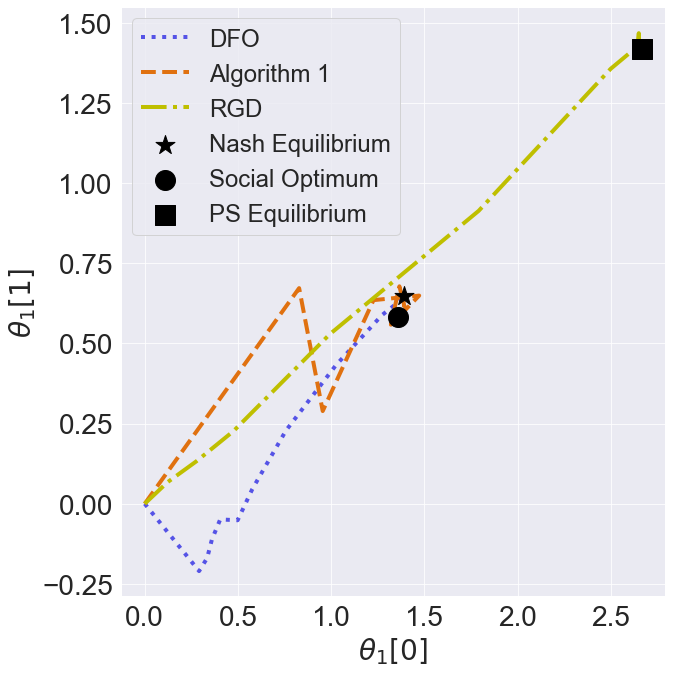

In [9]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 4

x3 = np.insert(np.array(theta_final_p3)[:,0],0,0)
y3 = np.insert(np.array(theta_final_p3)[:,1],0,0)
plt.plot(x3,y3,
         ls='dotted',label='DFO', color='#5553E6', lw=4)

x1 = np.insert(np.array(theta_final_p1)[:,0],0,0)
y1 = np.insert(np.array(theta_final_p1)[:,1],0,0)
plt.plot(x1,y1,
         '--', color='#E07110', label='Algorithm 1', lw=4)

x5 = np.insert(theta_final_p5[:,0],0,0)
y5 = np.insert(theta_final_p5[:,1],0,0)
plt.plot(x5,y5,
         '-.', color='y', label='RGD', lw=4)

x_nash_p1 = theta_PO_1[0]
y_nash_p1 = theta_PO_1[1]
plt.scatter(x_nash_p1, y_nash_p1,
            label='Nash Equilibrium', marker='*', color='k', s=400, zorder=10)

x_so_p1 = 1.35682
y_so_p1 = 0.581561
plt.scatter(x_so_p1, y_so_p1,
            label='Social Optimum', marker='o', color='k', s=400, zorder=10)

theta_5 = np.array(player_five.theta_history)
x_ps_p1 = np.mean(theta_5[-1000,0])
y_ps_p1 = np.mean(theta_5[-1000,1])
plt.scatter(x_ps_p1, y_ps_p1,
            label='PS Equilibrium', marker='s', color='k', s=400, zorder=10)

plt.legend(loc='best',fontsize=24)
plt.xlabel(r"$\theta_1[0]$")
plt.ylabel(r"$\theta_1[1]$")
plt.tight_layout()
plt.savefig('../figures/DD_regression_trajectory_steps.png', dpi=300, format='png')
plt.show()

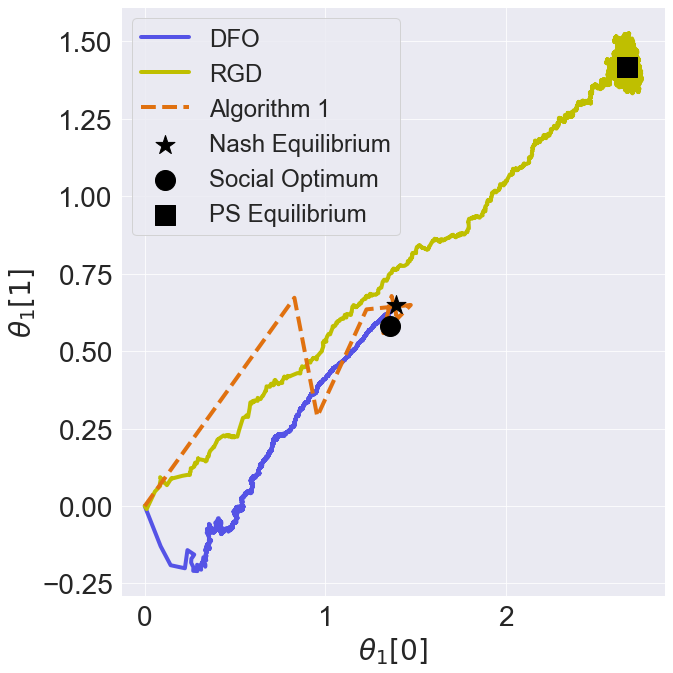

In [10]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 4

theta_3 = np.array(player_three.theta_history)
plt.plot(theta_3[:,0],theta_3[:,1],
         label='DFO', color='#5553E6', lw=4, zorder=5)

theta_5 = np.array(player_five.theta_history)
plt.plot(theta_5[:,0],theta_5[:,1],
         label='RGD', color='y', lw=4, zorder=6)

x1 = np.insert(theta_final_p1[:,0],0,0)
y1 = np.insert(theta_final_p1[:,1],0,0)
plt.plot(x1,y1,
         '--', color='#E07110', label='Algorithm 1', lw=4, zorder=7)

x_nash_p1 = theta_PO_1[0]
y_nash_p1 = theta_PO_1[1]
plt.scatter(x_nash_p1, y_nash_p1,
            label='Nash Equilibrium', marker='*', color='k', s=400, zorder=10)

x_so_p1 = 1.35682
y_so_p1 = 0.581561
plt.scatter(x_so_p1, y_so_p1,
            label='Social Optimum', marker='o', color='k', s=400, zorder=10)

x_ps_p1 = np.mean(theta_5[-1000,0])
y_ps_p1 = np.mean(theta_5[-1000,1])
plt.scatter(x_ps_p1, y_ps_p1,
            label='PS Equilibrium', marker='s', color='k', s=400, zorder=10)

plt.legend(loc='best',fontsize=24)
plt.xlabel(r"$\theta_1[0]$")
plt.ylabel(r"$\theta_1[1]$")
plt.tight_layout()
plt.savefig('../figures/DD_regression_trajectory.png', dpi=300, format='png')
plt.show()